# Class 13 - Starter Code

Natural Language Processing and Text Classification

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import json
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import ensemble
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

### Load Dataset and Pre-Process

We will continue to use the [Kaggle StumbleUpon Evergreen Classification Challenge](https://www.kaggle.com/c/stumbleupon) for this exercise.

This dataset comes from [StumbleUpon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

In [2]:
# Load data
data = pd.read_csv("../../assets/dataset/stumbleupon.tsv", sep='\t')

# Split `boilerplate` column
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 29 columns):
url                               7395 non-null object
urlid                             7395 non-null int64
boilerplate                       7395 non-null object
alchemy_category                  7395 non-null object
alchemy_category_score            7395 non-null object
avglinksize                       7395 non-null float64
commonlinkratio_1                 7395 non-null float64
commonlinkratio_2                 7395 non-null float64
commonlinkratio_3                 7395 non-null float64
commonlinkratio_4                 7395 non-null float64
compression_ratio                 7395 non-null float64
embed_ratio                       7395 non-null float64
framebased                        7395 non-null int64
frameTagRatio                     7395 non-null float64
hasDomainLink                     7395 non-null int64
html_ratio                        7395 non-null float64
image_r

In [3]:
# Drop missing values
data = data.dropna()

# Part 1: [Demo] Using `spacy`

In [4]:
# Set up spaCy
from spacy.en import English
nlp = English()

In [5]:
# Get a title to parse
title = data['title'].values[0]
print title
print type(title)

IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries
<type 'unicode'>


In [6]:
# Parse title using spacy
parsed = nlp(title)

# Print parsed results
for (i, word) in enumerate(parsed):
    print("Word: {}".format(word))
    print("\t Phrase type: {}".format(word.dep_))
    print("\t Is the word a known entity type? {}".format(
            word.ent_type_ if word.ent_type_ else "No"))
    print("\t Lemma: {}".format(word.lemma_))
    print("\t Parent of this word: {}".format(word.head.lemma_))
    if i > 5:
        break

Word: IBM 
	 Phrase type: compound
	 Is the word a known entity type? ORG
	 Lemma: ibm
	 Parent of this word: ibm
Word: Sees 
	 Phrase type: compound
	 Is the word a known entity type? ORG
	 Lemma: see
	 Parent of this word: ibm
Word: Holographic 
	 Phrase type: compound
	 Is the word a known entity type? ORG
	 Lemma: holographic
	 Parent of this word: ibm
Word: Calls 
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: call
	 Parent of this word: ibm
Word: Air 
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: air
	 Parent of this word: ibm
Word: Breathing 
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: breathing
	 Parent of this word: ibm
Word: Batteries 
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: battery
	 Parent of this word: ibm


# Part 2: [Review] Using Manual Text Features

### 2.1 How did we previously generate text features?
We manually created the `recipe_in_title` text feature.

In [7]:
# Check if title contains the word 'recipe'
data['recipe_in_title'] = data['title'].str.contains('recipe')

Accuracy: 0.557
ROC AUC: 0.588


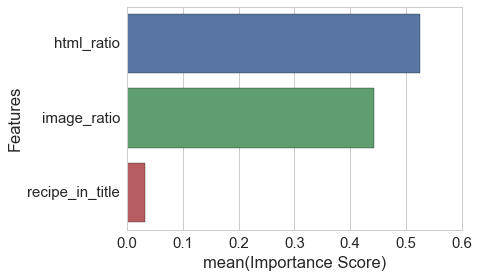

In [8]:
# Set features to use
existing_features = ['image_ratio', 'html_ratio']
new_text_features = ['recipe_in_title']
features = existing_features + new_text_features

# Set target variable name
target = 'label'

# Set X and y
X = data[features]
y = data[target]


# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=42)


# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])


# Plot feature importances
feature_names = X.columns
feature_importances = clf.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)
sns.barplot(y='Features', x='Importance Score', data=features_df)

# Part 3: [Demo] Using `CountVectorizer`

### 3.1 Count Vectorizer Demo
Use `CountVectorizer` to generate vectorized text features.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

In [10]:
corpus = ['This is the first document.',
          'This is the second second document.',
          'And the third one.',
          'Is this the first document?']

# Use `fit` to learn the vocabulary of the corpus
V = vectorizer.fit_transform(corpus)

In [11]:
# The dimensions of the vectorized matrix are
print "Dimensions of V:"
print V.shape

# Num. of rows = num of records in corpus
print "Records (documents/sentences) in Corpus:"
print len(corpus)

# Num. of columns = num of features
print "Size (words) in Vocabulary:"
print len(vectorizer.vocabulary_)

Dimensions of V:
(4, 9)
Records (documents/sentences) in Corpus:
4
Size (words) in Vocabulary:
9


In [12]:
# Get words in vocabulary
print vectorizer.vocabulary_

{u'and': 0, u'third': 7, u'this': 8, u'is': 3, u'one': 4, u'second': 5, u'the': 6, u'document': 1, u'first': 2}


In [13]:
vectorizer.transform(['This document is a completely new document.']).toarray()

array([[0, 2, 0, 1, 0, 0, 0, 0, 1]])

### 3.2 Generate Text Features for `data['title']` using Count Vectorizer
Use `CountVectorizer` to generate vectorized text features.

In [14]:
vectorizer = CountVectorizer(max_features=1000,
                             ngram_range=(1, 2),
                             stop_words='english',
                             binary=True)

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(data['title'])

# Use `tranform` to generate the vectorized matrix
X_new_text_features = vectorizer.transform(data['title'])

Accuracy: 0.735
ROC AUC: 0.799


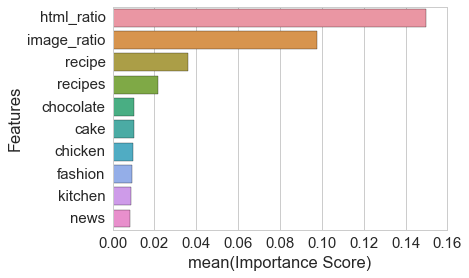

In [15]:
# Set features to use
existing_features = ['image_ratio', 'html_ratio']

# Set target variable name
target = 'label'

# Get X
X_existing_features = data[existing_features]

# Set X and y
X = sp.sparse.hstack((X_new_text_features, X_existing_features)).toarray()
y = data[target]


# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=42)


# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])


# Plot feature importances
feature_names = vectorizer.get_feature_names() + existing_features
feature_importances = clf.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)
sns.barplot(y='Features', x='Importance Score', data=features_df.head(10))

### 3.3 Generate Text Features for `data['body']` using Count Vectorizer
Use `CountVectorizer` to generate vectorized text feature for `data['body']`

In [16]:
# Create vectorized text feature matrix for data['body']

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(data['body'])

# Use `tranform` to generate the vectorized matrix
X_new_text_features = vectorizer.transform(data['body'])

In [ ]:
# Set features to use
existing_features = ['image_ratio', 'html_ratio']

# Set target variable name
target = 'label'

# Get X
X_existing_features = data[existing_features]

# Set X and y
X = sp.sparse.hstack((X_new_text_features, X_existing_features)).toarray()
y = data[target]


# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=42)


# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])


# Plot feature importances
feature_names = vectorizer.get_feature_names() + existing_features
feature_importances = clf.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)
sns.barplot(y='Features', x='Importance Score', data=features_df.head(10))

# Part 4: [Exercise] Using `TfidfVectorizer`

### 4.1 Generate Text Features for `data['body']` using TF-IDF Vectorizer
Use `TfidfVectorizer` to generate vectorized text features.
Does it perform better than `CountVectorizer`?

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create vectorized text feature matrix for data['body']

# Instantiate TfidfVectorizer
vectorizer = TfidfVectorizer()

# Use `fit` to learn the vocabulary of the corpus
V = vectorizer.fit_transform(corpus)

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(data['body'])

# Use `tranform` to generate the vectorized matrix
X_new_text_features = vectorizer.transform(data['body'])

In [ ]:
# Build RF model using 'image_ratio', 'html_ratio', and TF-IDF vectorized features for 'body'

# Set features to use
existing_features = ['image_ratio', 'html_ratio']

# Set target variable name
target = 'label'

# Get X
X_existing_features = data[existing_features]

# Set X and y
X = sp.sparse.hstack((X_new_text_features, X_existing_features)).toarray()
y = data[target]


# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=42)


# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=2)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])


# Plot feature importances
feature_names = vectorizer.get_feature_names() + existing_features
feature_importances = clf.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)
sns.barplot(y='Features', x='Importance Score', data=features_df.head(10))